### COSC522 Project 1 - Supervised Learning Using Baysian Decision Rule: Maximum Posterior Probability (MPP)

The objective of this project is to learn how to implement supervised learning algorithms based on Baysian decision theory, including both parametric learning (minimum Euclidean distance classifier, minimum Mahalanobis distance classifier, and quadratic machine) and non-parametric learning (k-nearest neighbor).

Sample code by Hairong Qi, hqi@utk.edu

In [68]:
import numpy as np
import sys
import time
import matplotlib.pyplot as plt

In [69]:
def readprior(s):
    """Specify the prior probabilities in the following format:
    label: value, label: value"""
    priors = {}
    pairs = s.strip().split(',')
    tot = 0
    for ele in pairs:
        i, p = ele.strip().split(":")
        priors[int(i)] = float(p)
        tot += float(p)
    if tot != 1.0:
        raise ValueError(f"aggregate p is {tot}, expect 1")
        
    return priors

In [70]:
def load_data(f):
    """ Assume data format:
    feature1 feature 2 ... label 
    """
    # process training data
    data = np.genfromtxt(f)
    # return all feature columns except last
    X = data[:, :-1]
    y = data[:, -1].astype(int)

    return X, y

In [71]:
def normalize(Tr, Te):
    """Normalize the training set and use the derived statistics to normalize the test set.
    """  
    trMean = np.mean(Tr, axis = 0)
    trStd = np.std(Tr, axis = 0)
    Tr = (Tr - trMean) / trStd
    Te = (Te - trMean) / trStd
    
    return Tr, Te

In [72]:
def accuracy_score(y, y_model):
    """ Return accuracy score in both overall and classwise manners.
    y: ground-truth label
    y_model: predicted label
    """   
    assert len(y) == len(y_model)

    classn = len(np.unique(y))    # number of different classes
    correct_all = y == y_model    # all correctly classified samples

    acc_overall = np.sum(correct_all) / len(y)
    acc_i = []        # this list stores classwise accuracy
    
    # calculate classwise accuracy
    for i in range(classn):
        GT_i = y == i            # samples actually belong to class i
        acc_i.append(np.sum(GT_i & correct_all) / np.sum(GT_i))

    return acc_i, acc_overall

In [73]:
class mpp:
    """Maximum Posterior Probability
    Supervised parametric learning assuming Gaussian pdf
    with 3 cases of discriminant functions. Cases should be 1, 2, or 3.
    """
    def __init__(self, case):
        self.case_ = case
        
    def fit(self, Tr, y):
        # derive the model 
        self.covs_, self.means_ = {}, {}     # dictionaries
        self.classes_ = np.unique(y)         # get unique labels as dictionary items
        self.classn_ = len(self.classes_)    # the number of classes in the dataset
        self.dimension_ = np.shape(Tr)[1]

        self.covsum_ = 0
        for c in self.classes_:
            arr = Tr[y == c]
            self.covs_[c] = np.cov(np.transpose(arr))
            self.means_[c] = np.mean(arr, axis=0)  # mean along rows
            self.covsum_ += self.covs_[c]

        # used by case II
        self.covavg_ = self.covsum_ / self.classn_

        # used by case I
        self.varavg_ = np.sum(np.diagonal(self.covavg_)) / self.dimension_
        
    def predict(self, Te, prior):
        # predict labels of all test data 
        disc = np.zeros(self.classn_)
        nr, _ = Te.shape
        y = np.zeros(nr)         # array to hold the predicted label
        
        for i in range(nr):         # going through each sample (or each row of the test set)
            for c in self.classes_:  # going through each class or category
                if self.case_ == 1:
                    edist2 = np.dot(Te[i]-self.means_[c], Te[i]-self.means_[c])
                    disc[c] = -edist2 / (2 * self.varavg_) + np.log(prior[c])
                elif self.case_ == 2: 
                    diff = Te[i] - self.means_[c]
                    mdist2 = np.dot(np.dot(diff, np.linalg.inv(self.covavg_)), diff)
                    disc[c] = -mdist2 / 2 + np.log(prior[c])
                elif self.case_ == 3:
                    diff = Te[i] - self.means_[c]
                    mdist2 = np.dot(np.dot(diff, np.linalg.inv(self.covs_[c])), diff)
                    disc[c] = -mdist2 / 2 - np.log(np.linalg.det(self.covs_[c])) / 2 + np.log(prior[c])
                else:
                    print("Can only handle case numbers 1, 2, 3.")
                    sys.exit(1)
            y[i] = disc.argmax() # note that I did not use randomness in the tie situation        
            
        return y

In [74]:
def knn(Tr, yTr, Te, k):
    """ k-Nearest Neighbor (kNN)
    Supervised non-parametric learning not assuming any pdf model
    """
    classes = np.unique(yTr)   # get unique labels as dictionary items
    classn = len(classes)      # number of classes
    ntr, _ = Tr.shape
    nte, _ = Te.shape
    
    y = np.zeros(nte)
    knn_count = np.zeros(classn)
    for i in range(nte):
        test = np.tile(Te[i,:], (ntr, 1))       # resembles MATLAB's repmat function
        dist = np.sum((test - Tr) ** 2, axis = 1) # calculate distance
        idist = np.argsort(dist)    # sort the array in the ascending order and return the index
        knn_label = yTr[idist[0:k]]
        for c in range(classn):
            knn_count[c] = np.sum(knn_label == c)
        y[i] = np.argmax(knn_count)
        
    return y    

Case	 Acc_Overall	 Acc_Classwise		 Runtime
1	0.713		0.680	0.746 		0.0255
2	0.892		0.900	0.884 		0.0251
3	0.898		0.908	0.888 		0.0407
kNN is going through all potential k values for the best overall accuracy ...
k=57	0.920		0.920	0.920 		0.0424


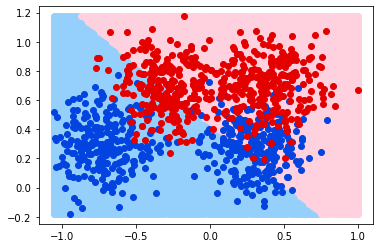

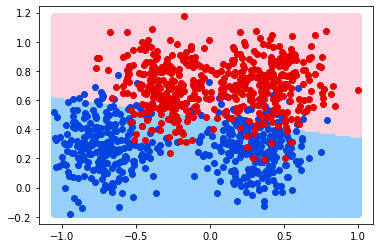

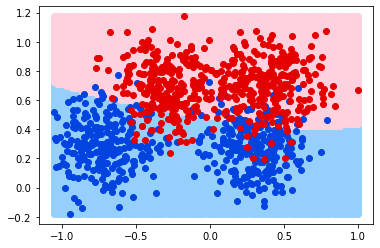

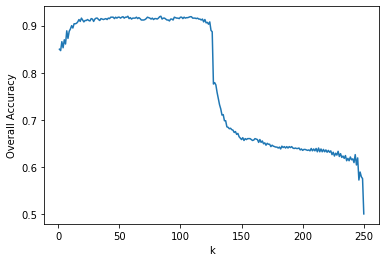

In [81]:
def main():
    # read in the datasets
    Xtrain, ytrain = load_data('data/synth.tr')
    Xtest, ytest = load_data('data/synth.te')

    # specify the prior probabilities
    prior = readprior("0:0.5, 1:0.5")
    
    # normalize datasets (synth is normalized already, no need to do it again)
    #Xtrain, Xtest = normalize(Xtrain, Xtest) 

    # prepare the meshgrid for plotting the decision boundary
    res = 100
    x = np.linspace(np.min(Xtest[:, 0]), np.max(Xtest[:, 0]), res)
    y = np.linspace(np.min(Xtest[:, 1]), np.max(Xtest[:, 1]), res)
    X, Y = np.meshgrid(x, y)
    XY = np.column_stack([X.flat, Y.flat])

    # test parametric learning
    print(f'Case\t Acc_Overall\t Acc_Classwise\t\t Runtime')    
    for cases in [1, 2, 3]:
        model = mpp(cases)                         # a new model    
        t0 = time.time()
        model.fit(Xtrain, ytrain)                  # train the model using the training set
        y_model = model.predict(Xtest, prior)      # test the model using the test set
        t1 = time.time()
        acc_classwise, acc_overall = accuracy_score(ytest, y_model)   # evaluate the performance of the model
        print(f'{cases}\t{acc_overall:.3f}\t\t{acc_classwise[0]:.3f}\t{acc_classwise[1]:.3f} \t\t{(t1 - t0):.4f}')
        
        y_boundary = model.predict(XY, prior)

        # plot the decision boundary: do the scatter plot of the test set
        plt.figure(cases)        
        arr = XY[y_boundary == 0]
        plt.scatter(arr[:, 0], arr[:, 1], c = "xkcd:light blue")
        arr = XY[y_boundary == 1]
        plt.scatter(arr[:, 0], arr[:, 1], c = "xkcd:light pink")
        
        arr = Xtest[ytest == 0]
        plt.scatter(arr[:, 0], arr[:, 1], c = "xkcd:blue")
        arr = Xtest[ytest == 1]
        plt.scatter(arr[:, 0], arr[:, 1], c = "xkcd:red")
                       
    # test non-parametric learning
    print(f'kNN is going through all potential k values for the best overall accuracy ...')
    k_acc = []
    avg_time = 0
    ntr, _ = Xtrain.shape
    for k in range(ntr):            # exhaustive search for the k value that results in the best overall accuracy
        t0 = time.time()
        y_model = knn(Xtrain, ytrain, Xtest, k + 1)
        t1 = time.time()
        avg_time += t1 - t0
        acc_classwise, acc_overall = accuracy_score(ytest, y_model)   # evaluate the performance of the model
        
        if k == 0:            
            acc_classwise_highest = acc_classwise
            acc_overall_highest = acc_overall
            k_highest = k + 1
        else:
            if acc_overall_highest < acc_overall:
                acc_classwise_highest = acc_classwise
                acc_overall_highest = acc_overall
                k_highest = k + 1
        k_acc.append(acc_overall)
    avg_time /= ntr
    print(f'k={k_highest}\t{acc_overall_highest:.3f}\t\t{acc_classwise_highest[0]:.3f}\t{acc_classwise_highest[1]:.3f} \t\t{avg_time:.4f}')  
    
    # plot acc_overall vs. k
    index = np.arange(1, ntr + 1)      # so that the plot starts at k=1 not k=0
    plt.figure(4)
    plt.plot(index, k_acc)
    plt.ylabel('Overall Accuracy')
    plt.xlabel('k')
    
    plt.show()
    

        
    
if __name__ == "__main__":
    main()